In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
import sys
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.16.1


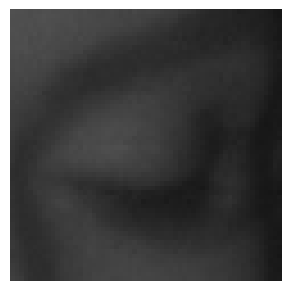

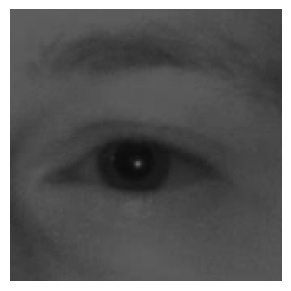

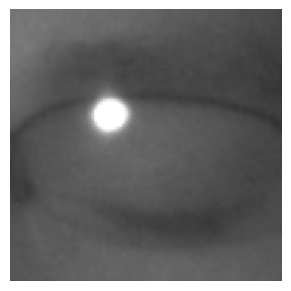

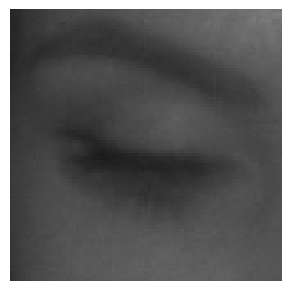

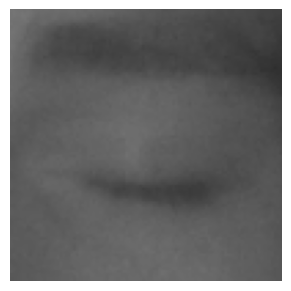

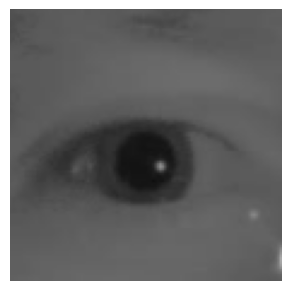

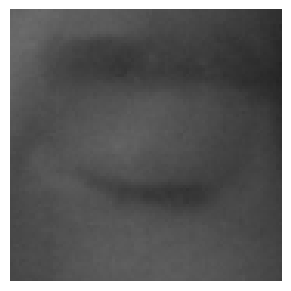

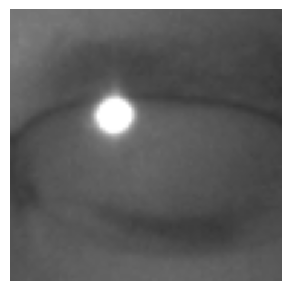

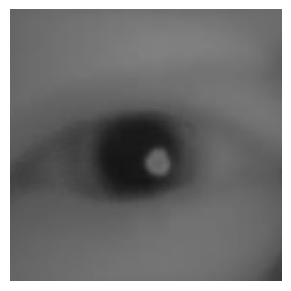

In [2]:
images = glob("mrlEyes_2018_01/train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize = (12,12))
    plt.subplot(331 + i)
    plt.imshow(cv2.imread(image));  plt.axis('off')

In [3]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("mrlEyes_2018_01/train/",
                                                   target_size = (img_size, img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("mrlEyes_2018_01/test/",
                                                   target_size = (img_size, img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 5917 images belonging to 2 classes.
Found 1199 images belonging to 2 classes.


In [4]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [5]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [6]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv1 = Convolution(inputs, 32, (3,3))
    conv2 = Convolution(inputs, 64, (5,5))
    conv3 = Convolution(inputs, 128, (3,3))
    
    flatten = Flatten()(conv3)
    
    dense_1 = Dense_f(flatten, 256)
    
    output = Dense(2, activation = "sigmoid")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    
    model.compile(loss = ['binary_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [7]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,877,954 (72.01 MB)

 Trainable params: 18,877,186 (72.01 MB)

 Non-trainable params: 768 (3.00 KB)

In [8]:
# file_path = r'C:\Users\shrey\OneDrive\Desktop\Emotional Detector\model.weights.h5'#.encode(sys.getfilesystemencoding()).decode()
epochs = 20
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint('model_1.weights.h5', monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose = 1)
callbacks = [checkpoint]

In [9]:
history = model.fit(
        x = train_generator,
        steps_per_epoch = steps_per_epoch,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = validation_steps,
        callbacks = callbacks)

Epoch 1/20


c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9132 - loss: 0.2281
Epoch 1: saving model to model_1.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9138 - loss: 0.2268 - val_accuracy: 0.6606 - val_loss: 2.1475
Epoch 2/20
 1/92 ━━━━━━━━━━━━━━━━━━━━ 1:31 1s/step - accuracy: 0.9844 - loss: 0.0507
Epoch 2: saving model to model_1.weights.h5


c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9844 - loss: 0.0256 - val_accuracy: 0.7234 - val_loss: 0.8439
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9938 - loss: 0.0300
Epoch 3: saving model to model_1.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9938 - loss: 0.0300 - val_accuracy: 0.3160 - val_loss: 3.3379
Epoch 4/20
 1/92 ━━━━━━━━━━━━━━━━━━━━ 2:15 1s/step - accuracy: 1.0000 - loss: 0.0224
Epoch 4: saving model to model_1.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 0.2766 - val_loss: 1.9599
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9958 - loss: 0.0167
Epoch 5: saving model to model_1.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9958 - loss: 0.0167 - val_accuracy: 0.3151 - val_loss: 3.5661
Epoch 6/20
 1/92 ━━━━━━━━━━━━━━━━━━━━ 1:18 865ms/step - accuracy: 1.0000 - loss: 0.0101
Epoch 6: saving model to model_1.weights.h5
92/92 ━━━━━━━━━━━━━━━━

In [10]:
model.save("model_1.weights.h5")

In [11]:
# Get a batch of validation data and labels
validation_batch = next(validation_generator)

# Print the shapes
print(f"Validation data shape: {validation_batch[0].shape}")
print(f"Validation labels shape: {validation_batch[1].shape}")

Validation data shape: (64, 48, 48, 1)
Validation labels shape: (64, 2)


In [12]:
model.evaluate(validation_generator)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.3113 - loss: 2.7830


[2.7401163578033447, 0.31526270508766174]

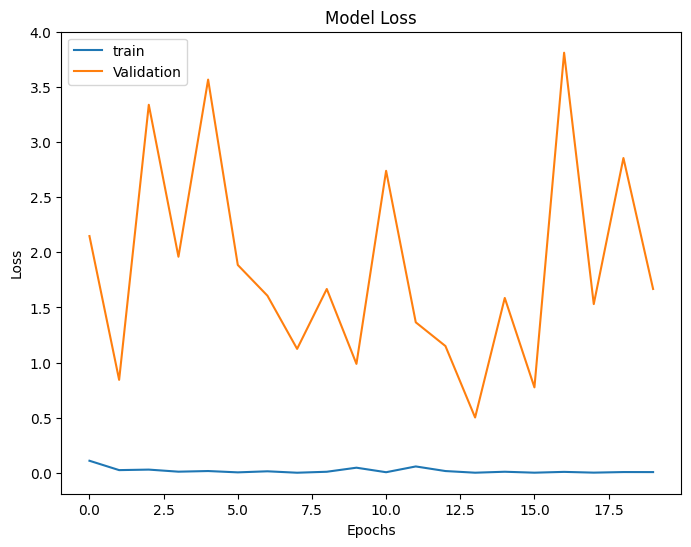

In [13]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.title("Model Loss")
plt.legend(['train','Validation'], loc = 'upper left')
# plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()
plt.show()

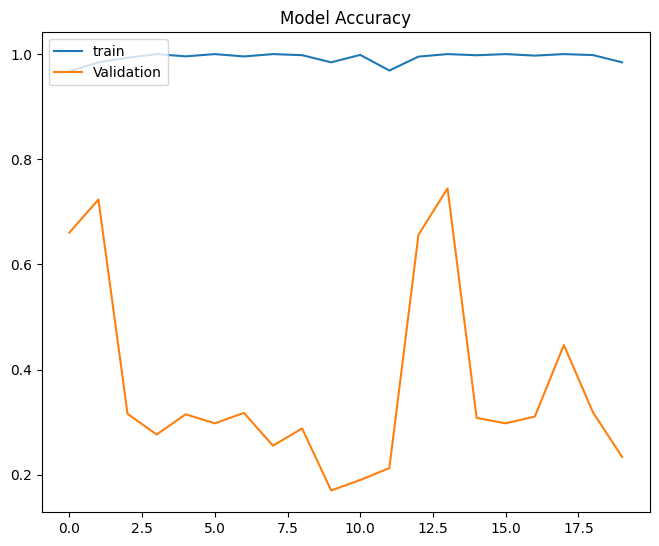

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.legend(['train','Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

In [15]:
model_json = model.to_json()
with open("model_1_a.json", "w") as json_file:
    json_file.write(model_json)